<a href="https://colab.research.google.com/github/s2ul2/jpx-dokyo-stock-prices-analysis/blob/main/LSTM_%EC%84%9C%EC%A7%84%EC%8A%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
df2 = pd.read_csv('/content/drive/MyDrive/AI딥러닝_프로젝트/데이터/train_files.csv')
df2

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/AI딥러닝_프로젝트/데이터/mooyaho3.csv')
df.isnull().sum()

Unnamed: 0         0
Unnamed: 0.1       0
Date               0
SecuritiesCode     0
Open               0
High               0
Low                0
Volume             0
Target             0
AdjustedClose      0
RSI               20
MA                19
EMA               19
MOM               20
ATR               20
dtype: int64

In [ ]:
%cd /content/drive/MyDrive/AI딥러닝_프로젝트/데이터/jpx-tokyo-stock-exchange-prediction

/content/drive/MyDrive/AI딥러닝_프로젝트/데이터/jpx-tokyo-stock-exchange-prediction


In [ ]:
import pandas as pd

In [ ]:
%ls

data_specifications/          stock_list.csv       train_files/
example_test_files/           submission.csv
jpx_tokyo_market_prediction/  supplemental_files/


In [ ]:
import pandas as pd
import numpy as np
import warnings
import os
from functools import reduce
warnings.filterwarnings(action='ignore')

import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
sns.set_palette("pastel")
%matplotlib inline

In [ ]:
import numpy as np
import pandas as pd

from lightgbm import LGBMRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder

import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

import warnings
warnings.filterwarnings("ignore")

In [ ]:
price_ta = pd.read_csv('ta_stock_prices.csv')
price_ta = price_ta.drop('Unnamed: 0', axis = 1)

In [ ]:
prices = pd.read_csv("/content/drive/MyDrive/AI딥러닝_프로젝트/데이터/jpx-tokyo-stock-exchange-prediction/train_files/stock_prices.csv")
prices = prices.drop("ExpectedDividend", axis=1)
prices = prices.dropna()
prices.isnull().sum()

RowId               0
Date                0
SecuritiesCode      0
Open                0
High                0
Low                 0
Close               0
Volume              0
AdjustmentFactor    0
SupervisionFlag     0
Target              0
dtype: int64

# CV-split

In [ ]:
# cross validation split
def setup_cv(df, splits=5):
    df['fold'] = -1
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    num_bins = int(np.floor(1 + np.log2(len(df))))
    df.loc[:, "bins"] = pd.cut(
        df["Target"], bins=num_bins, labels=False
    )

    kf = StratifiedKFold(n_splits=splits)
    for f, (t_, v_) in enumerate(kf.split(X=df, y=df.bins.values)):
            df.loc[v_, 'fold'] = f

    df = df.drop("bins", axis=1)
    return df

In [ ]:
prices = setup_cv(prices)

In [ ]:
enc = OrdinalEncoder()
prices["SecuritiesCode"] = enc.fit_transform(prices[["SecuritiesCode"]])

In [ ]:
prices

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,SupervisionFlag,Target,fold
0,20190624_5410,2019-06-24,876.0,1980.0,1980.0,1951.0,1956.0,71000,1.0,False,-0.012314,0
1,20180808_2317,2018-08-08,166.0,1341.0,1378.0,1331.0,1363.0,542500,1.0,False,-0.008876,0
2,20210820_8771,2021-08-20,1726.0,2180.0,2195.0,2148.0,2184.0,48600,1.0,False,0.026118,0
3,20210512_8056,2021-05-12,1548.0,3425.0,3445.0,3275.0,3295.0,469000,1.0,False,0.025357,0
4,20200330_8129,2020-03-30,1579.0,2337.0,2438.0,2301.0,2438.0,280300,1.0,False,-0.025143,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2324918,20180801_1799,2018-08-01,34.0,1779.0,1792.0,1760.0,1792.0,5500,1.0,False,0.020822,4
2324919,20170330_3951,2017-03-30,514.0,2659.0,2700.0,2659.0,2700.0,8500,1.0,False,-0.020045,4
2324920,20200818_6965,2020-08-18,1258.0,4940.0,4990.0,4920.0,4975.0,257700,1.0,False,-0.020305,4
2324921,20210924_9450,2021-09-24,1863.0,1530.0,1550.0,1517.0,1549.0,156600,1.0,False,-0.024224,4


# LGBM

In [ ]:
# LGBM
def train_lgbm(prices, folds):
    models = list()
    
    for f in range(folds):
        X_train = prices[prices.fold != f][["SecuritiesCode", "Open", "High", "Low", "Close"]]
        y_train = prices[prices.fold != f][["Target"]]
        X_valid = prices[prices.fold == f][["SecuritiesCode", "Open", "High", "Low", "Close"]]
        y_valid = prices[prices.fold == f][["Target"]]
        
        model = LGBMRegressor()
        model.fit(X_train, y_train)
        oof_preds = model.predict(X_valid)
        oof_score = np.sqrt(mean_squared_error(y_valid, oof_preds))
        print(oof_score)
        models.append(model)
        
    return models

# DNN

In [ ]:
# DNN
codes = list(prices.SecuritiesCode.unique())
codes_size = len(codes)

def dense_block(x, units, act='swish', dr=0.2):
    x = L.Dropout(dr)(x)
    x = L.BatchNormalization()(x)
    x = L.Dense(units, activation=act)(x)
    return x

def get_dnn(dense_blocks):
    prices_in = L.Input(shape=(4,), name='input_prices')  # L : layers
    x_prices = L.BatchNormalization()(prices_in)
    x_prices = L.Dense(64, activation='swish')(x_prices)
    
    security_code_input = L.Input(shape=(1,), name='input_security_code')
    x_id = L.Embedding(codes_size, 32, input_length=1)(security_code_input)
    x_id = L.Reshape((-1, ))(x_id)
    x_id = L.Dense(32, activation='swish')(x_id)

    x = L.Concatenate(axis=1)([x_id, x_prices])
    
    for units in dense_blocks:
        x = dense_block(x, units)
    
    output = L.Dense(1)(x)
    
    model = M.Model([prices_in, security_code_input], 
                    [output])

    model.compile(optimizer=tf.optimizers.Adam(lr=0.001),
                  loss='mse', metrics=['mse'])
    
    return model
    
def train_dnn(prices, folds):
    models = list()
    
    for f in range(folds):
        X_train_prices = prices[prices.fold != f][["Open", "High", "Low", "Close"]]
        X_train_id = prices[prices.fold != f][["SecuritiesCode"]]
        y_train = prices[prices.fold != f][["Target"]]
        X_valid_prices = prices[prices.fold == f][["Open", "High", "Low", "Close"]]
        X_valid_id = prices[prices.fold == f][["SecuritiesCode"]]
        y_valid = prices[prices.fold == f][["Target"]]

        model = get_dnn([128]) # , 64, 32
        model.fit([X_train_prices, X_train_id], y_train,
                   validation_data=([X_valid_prices, X_valid_id], y_valid),
                   batch_size=128, epochs=15, verbose=0)

        oof_preds = model.predict([X_valid_prices, X_valid_id])
        oof_score = np.sqrt(mean_squared_error(y_valid, oof_preds))
        print(oof_score)
        models.append(model)
        break
        # break for speed of training, feel free to train all folds
    
    return models

In [ ]:
# Run - prints rmse for each fold
lgbm_models = train_lgbm(prices, 5)

0.023382704221489446
0.02338802550542154
0.023358557163261778
0.02340790713742689
0.023414143816400203


In [ ]:
dnn_models = train_dnn(prices, 5)

KeyboardInterrupt: ignored

In [ ]:
kaggle competitions download -c jpx-tokyo-stock-exchange-prediction

SyntaxError: ignored

In [ ]:
!pip install <jpx_tokyo_market_prediction>

/bin/bash: -c: line 0: syntax error near unexpected token `newline'
/bin/bash: -c: line 0: `pip install <jpx_tokyo_market_prediction>'


# Prediction

In [ ]:
import jpx_tokyo_market_prediction

ModuleNotFoundError: ignored

In [ ]:
# Make Predictions & Submit
env = jpx_tokyo_market_prediction.make_env()   # initialize the environment
iter_test = env.iter_test()    # an iterator which loops over the test files

for (prices, options, financials, trades, secondary_prices, sample_prediction) in iter_test:
    prices["SecuritiesCode"] = enc.fit_transform(prices[["SecuritiesCode"]])
    
    X_test = prices[["SecuritiesCode", "Open", "High", "Low", "Close"]]
    lgbm_preds = list()
    for model in lgbm_models:
        lgbm_preds.append( model.predict(X_test) )
    lgbm_preds = np.mean(lgbm_preds, axis=0)
    
    X_test_prices = prices[["Open", "High", "Low", "Close"]]
    X_test_id = prices[["SecuritiesCode"]]
    dnn_preds = list()
    for model in dnn_models:
        dnn_preds.append( model.predict([X_test_prices, X_test_id]) )
    dnn_preds = np.mean(dnn_preds, axis=0)[0]
    
    sample_prediction["Prediction"] = lgbm_preds*0.8 + dnn_preds*0.2 ####################### 왜 이렇게 비율을 설정했지
    
    sample_prediction = sample_prediction.sort_values(by = "Prediction", ascending=False)
    sample_prediction.Rank = np.arange(0,2000)
    sample_prediction = sample_prediction.sort_values(by = "SecuritiesCode", ascending=True)
    sample_prediction.drop(["Prediction"],axis=1)
    submission = sample_prediction[["Date","SecuritiesCode","Rank"]]
    env.predict(submission)


In [ ]:
pd.read_csv("./submission.csv")

+ 추후 :  불린저 밴드, MACD, DMI 등을 변수에 추가해보자!


# LSTM

In [ ]:
import jpx_tokyo_market_prediction
env = jpx_tokyo_market_prediction.make_env()
iter_test = env.iter_test()

Exception: ignored

In [ ]:
iter_test

In [ ]:
%ls

data_specifications/  jpx_tokyo_market_prediction/  supplemental_files/
example_test_files/   stock_list.csv                train_files/


In [ ]:
stock_price_df = pd.read_csv("/content/drive/MyDrive/AI딥러닝_프로젝트/데이터/jpx-tokyo-stock-exchange-prediction/train_files/stock_prices.csv")

In [ ]:
# create dataset
stock_price_df = stock_price_df.drop('ExpectedDividend', axis = 1)
stock_price_df['SupervisionFlag'] = stock_price_df['SupervisionFlag'].map({True: 1, False: 0})
stock_price_df['Date'] = pd.to_datetime(stock_price_df['Date'])
stock_price_df.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,0,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,0,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,0,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,0,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,0,0.003026


In [ ]:
stock_price_df = stock_price_df.dropna(how='any')
# Confirmation of missing information
stock_price_df_na = (stock_price_df.isnull().sum() / len(stock_price_df)) * 100
stock_price_df_na = stock_price_df_na.drop(stock_price_df_na[stock_price_df_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :stock_price_df_na})
missing_data.head(22)

,Missing Ratio


In [ ]:
np.ceil(stock_price_df['Date'].nunique() * 0.8)

962.0

In [ ]:
stock_price_df['Date'].unique()

array(['2017-01-04', '2017-01-05', '2017-01-06', ..., '2021-12-01',
       '2021-12-02', '2021-12-03'], dtype=object)

In [ ]:
stock_price_df['Date'].unique()[962]

'2020-12-11'

2020-12-11일 까지 train, 그 이후는 test

In [ ]:
# train, test split
train_df = stock_price_df[(stock_price_df['Date']<'2020-12-11') == True]
test_df = stock_price_df[(stock_price_df['Date']<'2020-12-11') == False]

In [ ]:
# create LSTM model
import torch
import torch.nn as nn
import torch.nn.functional as F

class LSTM(nn.Module):
    def __init__(self, input_size=8, sequence_num=31, lstm_dim=128,
                 num_layers=2, output_size=1):
        super().__init__()
        
        self.lstm = nn.LSTM(input_size, lstm_dim, num_layers, batch_first=True, bidirectional=True)
        self.linear1 = nn.Linear(lstm_dim*sequence_num*2, 1)
        self.bn1 = nn.BatchNorm1d(lstm_dim*sequence_num*2)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        x = lstm_out.reshape(lstm_out.shape[0], -1)
        x = self.linear1(self.bn1(x))
        return x

In [ ]:
# train 데이터 scaling
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'AdjustmentFactor', 'SupervisionFlag']
train_df[columns] = stdsc.fit_transform(train_df[columns])
train_df.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,0.062786,0.059048,0.072137,0.065252,-0.163970,-0.008676,-0.022845,0.000730
1,20170104_1332,2017-01-04,1332,-0.588727,-0.588938,-0.587459,-0.587793,0.498531,-0.008676,-0.022845,0.012324
2,20170104_1333,2017-01-04,1333,0.187915,0.194354,0.196934,0.206028,-0.106652,-0.008676,-0.022845,0.006154
3,20170104_1376,2017-01-04,1376,-0.305382,-0.299292,-0.299209,-0.293306,-0.168782,-0.008676,-0.022845,0.011053
4,20170104_1377,2017-01-04,1377,0.224010,0.235987,0.236503,0.242125,-0.135383,-0.008676,-0.022845,0.003026


In [ ]:
dataset_dict = {}
for sc in train_df['SecuritiesCode'].unique():
    dataset_dict[str(sc)] = train_df[train_df['SecuritiesCode'] == sc].values[:, 3:].astype(np.float32)
print(dataset_dict['1301'].shape)

(961, 8)


In [ ]:
test_dataset_dict = {}
for sc in test_df['SecuritiesCode'].unique():
    dataset_dict[str(sc)] = test_df[test_df['SecuritiesCode'] == sc].values[:, 3:].astype(np.float32)
print(dataset_dict['1301'].shape)

(240, 8)


In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, X, sequence_num=31, y=None, mode='train'):
        self.data = X
        self.teacher = y
        self.sequence_num = sequence_num
        self.mode = mode
    def __len__(self):
        return len(self.teacher)

    def __getitem__(self, idx):
        out_data = self.data[idx]
        if self.mode == 'train':
            out_label =  self.teacher[idx[-1]]
            return out_data, out_label
        else:
            return out_data
def create_dataloader(dataset, dataset_num, sequence_num=31, input_size=8, batch_size=32, shuffle=False):
    sampler = np.array([list(range(i, i+sequence_num)) for i in range(dataset_num-sequence_num+1)])
    if shuffle == True:
        np.random.shuffle(sampler)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size, sampler=sampler)
    return dataloader
#### Check operation ####
X_check, y_check = dataset_dict['1301'][:, :-1], dataset_dict['1301'][:, -1]
dataset_check = MyDataset(X_check, y=y_check, sequence_num=31, mode='train')
dataloader_check = create_dataloader(dataset_check, X_check.shape[0], sequence_num=31, input_size=7, batch_size=32, shuffle=False)
for b, tup in enumerate(dataloader_check):
    print('---------')
    print(tup[0].shape, tup[1].shape)
    break

---------
torch.Size([32, 31, 7]) torch.Size([32])


In [ ]:
from tqdm import tqdm
for sc in tqdm(train_df['SecuritiesCode'].unique()):
    X, y = dataset_dict[str(sc)][:, :-1], dataset_dict[str(sc)][:, -1]

100%|██████████| 1991/1991 [00:00<00:00, 350449.42it/s]


In [ ]:
X.shape

(240, 7)

In [ ]:
# training
from tqdm import tqdm
epochs = 3 # 원래 10
batch_size = 512
# Check wheter GPU is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Model Instantiation
model = LSTM(input_size=7, sequence_num=31, lstm_dim=128, num_layers=2, output_size=1)
model.to(device)
model.train()
# setting optimizer
lr = 0.0001
weight_decay = 1.0e-05
optimizer = torch.optim.Adagrad(model.parameters(), lr=lr, weight_decay=weight_decay)
# setting criterion
criterion = nn.MSELoss()
# set iteration counter
iteration = 0
# 
log_train = [[0], [np.inf]]
for epoch in range(epochs):
    epoch_loss = 0.0
    for sc in tqdm(train_df['SecuritiesCode'].unique()):
        X, y = dataset_dict[str(sc)][:, :-1], dataset_dict[str(sc)][:, -1]
        dataset = MyDataset(X, y=y, sequence_num=31, mode='train')
        dataloader = create_dataloader(dataset, X.shape[0], sequence_num=31, input_size=7, batch_size=batch_size, shuffle=True)
        for data, targets in dataloader:
            data, targets = data.to(device), targets.to(device)
            
            optimizer.zero_grad()
            
            data = data.to(torch.float32)
            output = model.forward(data)
            targets = targets.to(torch.float32)
            
            loss = criterion(output.view(1,-1)[0], targets)
            
            loss.backward()
            
            optimizer.step()
            
            epoch_loss += loss.item()
            
            iteration += 1
    epoch_loss /= iteration
    print('epoch_loss={}'.format(epoch_loss))
    log_train[0].append(iteration)
    log_train[1].append(epoch_loss)

100%|██████████| 1991/1991 [01:32<00:00, 21.61it/s]


epoch_loss=0.002837149608514034


100%|██████████| 1991/1991 [01:34<00:00, 21.16it/s]


epoch_loss=0.0007904093088185606


100%|██████████| 1991/1991 [01:36<00:00, 20.68it/s]

epoch_loss=0.0004549789762452756


In [ ]:
# model.save(f'lstm_model_naive.h5')

AttributeError: ignored

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


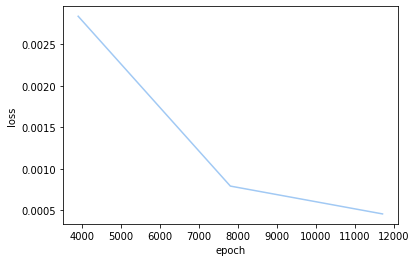

In [ ]:
import matplotlib.pyplot as plt
plt.plot(log_train[0][1:], log_train[1][1:])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
import jpx_tokyo_market_prediction
# env = jpx_tokyo_market_prediction.make_env()
#iter_test = env.iter_test()

In [ ]:
# prediction
from datetime import datetime
def predict(model, X_df, sequence=31):
    pred_df = X_df[['Date', 'SecuritiesCode']]
    # Grouping by `groupby` and retrieving one by one
    code_group = X_df.groupby('SecuritiesCode')
    X_all = np.array([])
    for sc, group in code_group:
        # Standardize target data
        group_std = stdsc.transform(group[columns])
        # Calling up past data of the target data
        X = dataset_dict[str(sc)][-1*(sequence-1):, :-1]
        # concat
        X = np.vstack((X, group_std))
        X_all = np.append(X_all, X)
    X_all = X_all.reshape(-1, sequence, X.shape[1])
    y_pred = np.array([])
    for it in range(X_all.shape[0]//512+1):
        data = X_all[it*512:(it+1)*512]
        data = torch.from_numpy(data.astype(np.float32)).clone()
        data = data.to(torch.float32)
        data = data.to(device)
        output = model.forward(data)
        output = output.view(1, -1)
        output = output.to('cpu').detach().numpy().copy()
        y_pred = np.append(y_pred, output[0])
    pred_df['target'] = y_pred
    pred_df['Rank'] = pred_df["target"].rank(ascending=False,method="first") -1
    pred_df['Rank'] = pred_df['Rank'].astype(int)
    pred_df = pred_df.drop('target', axis=1)
    return pred_df
test_X_df = stock_price_df[stock_price_df['Date'] == datetime(2021, 12, 3)].drop('Target', axis=1) # 2021년 12월 3일 target값 예측
y_pred = predict(model, test_X_df)
print(y_pred.shape)
print(y_pred)

(1995, 3)
              Date  SecuritiesCode  Rank
2330531 2021-12-03            1301   513
2330532 2021-12-03            1332  1255
2330533 2021-12-03            1333   652
2330534 2021-12-03            1375   869
2330535 2021-12-03            1376   774
...            ...             ...   ...
2332526 2021-12-03            9990  1780
2332527 2021-12-03            9991  1678
2332528 2021-12-03            9993  1222
2332529 2021-12-03            9994   789
2332530 2021-12-03            9997  1729

[1995 rows x 3 columns]


In [ ]:
count = 0
for (prices, options, financials, trades, secondary_prices, sample_prediction) in iter_test:
    prices = prices.fillna(0)
    prices['SupervisionFlag'] = prices['SupervisionFlag'].map({True: 1, False: 0})
    prices['Date'] = pd.to_datetime(prices['Date'])
    pred_df = predict(model, prices)
    print(pred_df)
    env.predict(pred_df)
    count += 1

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
           Date  SecuritiesCode  Rank
0    2021-12-06            1301  1056
1    2021-12-06            1332   473
2    2021-12-06            1333   791
3    2021-12-06            1375   329
4    2021-12-06            1376   332
...         ...             ...   ...
1995 2021-12-06            9990  1708
1996 2021-12-06            9991  1651
1997 2021-12-06            9993  1400
1998 2021-12-06            9994   950
1999 2021-12-06            9997  1643

[2000 rows x 3 columns]
           Date  SecuritiesCode  Rank
0    2021-12-07            1301  1080
1    2021-12-07            1332   540
2    2021-12-07            1333   783
3    2021-12-07            1375   325
4    2021-12-07            1376   326
...         ...             ...   ...
1995 2021-12-07            9990  1713
1996 2021-12-07            9991  1653
1997 2021-12-07            9993  1394
1998 2021-12-0

In [ ]:
pred_df

,Date,SecuritiesCode,Rank
0,2021-12-07,1301,1080
1,2021-12-07,1332,540
2,2021-12-07,1333,783
3,2021-12-07,1375,325
4,2021-12-07,1376,326
...,...,...,...
1995,2021-12-07,9990,1713
1996,2021-12-07,9991,1653
1997,2021-12-07,9993,1394
1998,2021-12-07,9994,956


In [ ]:
price_ta = pd.read_csv('/content/drive/MyDrive/AI딥러닝_프로젝트/데이터/jpx-tokyo-stock-exchange-prediction/train_files/ta_stock_prices.csv')
price_ta = price_ta.drop('Unnamed: 0', axis = 1)
price_ta


,RowId,Date,SecuritiesCode,Open,High,Low,Volume,AdjustmentFactor,SupervisionFlag,index,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,31400,1.0,False,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-11.025925,NaN,0.000000
1,20170105_1301,2017-01-05,1301,2743.0,2747.0,2735.0,17900,1.0,False,1865.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.145879,-0.145985,-0.145879
2,20170106_1301,2017-01-06,1301,2734.0,2744.0,2720.0,19900,1.0,False,3730.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.073046,0.073019,-0.072939
3,20170110_1301,2017-01-10,1301,2745.0,2754.0,2735.0,24200,1.0,False,5595.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.291971,0.291545,0.218818
4,20170111_1301,2017-01-11,1301,2748.0,2752.0,2737.0,9300,1.0,False,7460.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.109170,-0.109230,0.109409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332526,20211129_4169,2021-11-29,4169,6970.0,7350.0,6970.0,772500,1.0,False,2323102.0,...,12.272497,12.882080,-0.609583,-6.583499,-8.379071,1.795573,7820.097674,-17.709563,-19.491528,159.880686
2332527,20211130_4169,2021-11-30,4169,6770.0,7240.0,6410.0,887400,1.0,False,2325102.0,...,10.729472,12.451558,-1.722086,-3.864778,-7.476213,3.611434,7803.953996,0.717360,0.714799,161.744966
2332528,20211201_4169,2021-12-01,4169,7190.0,7380.0,6670.0,496800,1.0,False,2327102.0,...,9.477017,11.856650,-2.379633,-6.091743,-7.199319,1.107576,7794.048336,0.997151,0.992212,164.354959
2332529,20211202_4169,2021-12-02,4169,7160.0,7870.0,7110.0,783000,1.0,False,2329102.0,...,8.855025,11.256325,-2.401300,-4.530019,-6.665459,2.135440,7783.225133,6.064880,5.888080,180.387770


In [ ]:
price_ta.columns

Index(['RowId', 'Date', 'SecuritiesCode', 'Open', 'High', 'Low', 'Volume',
       'AdjustmentFactor', 'SupervisionFlag', 'index', 'CloseMean',
       'new_target', 'log_volume', 'volume_adi', 'volume_obv', 'volume_cmf',
       'volume_fi', 'volume_em', 'volume_sma_em', 'volume_vpt', 'volume_vwap',
       'volume_mfi', 'volume_nvi', 'volatility_bbm', 'volatility_bbh',
       'volatility_bbl', 'volatility_bbw', 'volatility_bbp', 'volatility_bbhi',
       'volatility_bbli', 'volatility_kcc', 'volatility_kch', 'volatility_kcl',
       'volatility_kcw', 'volatility_kcp', 'volatility_kchi',
       'volatility_kcli', 'volatility_dcl', 'volatility_dch', 'volatility_dcm',
       'volatility_dcw', 'volatility_dcp', 'volatility_atr', 'volatility_ui',
       'trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff',
       'trend_trix', 'trend_ma

In [ ]:
price_ta2 = price_ta[['RowId', 'Date', 'SecuritiesCode', 'Open', 'High', 'Low', 'CloseMean', 'Volume',
       'AdjustmentFactor', 'SupervisionFlag',
       'new_target',     "momentum_rsi",
    "trend_macd",
    "trend_kst",
    "trend_ema_fast",
    "volatility_bbm",
    "volatility_atr" ]]

In [ ]:
price_ta2.shape

(2332531, 17)

In [ ]:
# create LSTM model
import torch
import torch.nn as nn
import torch.nn.functional as F

class LSTM(nn.Module):
    def __init__(self, input_size=14, sequence_num=31, lstm_dim=128,
                 num_layers=2, output_size=1):
        super().__init__()
        
        self.lstm = nn.LSTM(input_size, lstm_dim, num_layers, batch_first=True, bidirectional=True)
        self.linear1 = nn.Linear(lstm_dim*sequence_num*2, 1)
        self.bn1 = nn.BatchNorm1d(lstm_dim*sequence_num*2)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        x = lstm_out.reshape(lstm_out.shape[0], -1)
        x = self.linear1(self.bn1(x))
        return x

In [ ]:
# create dataset
price_ta2['SupervisionFlag'] = price_ta2['SupervisionFlag'].map({True: 1, False: 0})
price_ta2['Date'] = pd.to_datetime(price_ta2['Date'])
price_ta2.head()

,RowId,Date,SecuritiesCode,Open,High,Low,CloseMean,Volume,AdjustmentFactor,SupervisionFlag,new_target,momentum_rsi,trend_macd,trend_kst,trend_ema_fast,volatility_bbm,volatility_atr
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,0,0.000730,NaN,NaN,NaN,NaN,NaN,0.0
1,20170105_1301,2017-01-05,1301,2743.0,2747.0,2735.0,2738.0,17900,1.0,0,0.002920,NaN,NaN,NaN,NaN,NaN,0.0
2,20170106_1301,2017-01-06,1301,2734.0,2744.0,2720.0,2740.0,19900,1.0,0,-0.001092,NaN,NaN,NaN,NaN,NaN,0.0
3,20170110_1301,2017-01-10,1301,2745.0,2754.0,2735.0,2748.0,24200,1.0,0,-0.005100,NaN,NaN,NaN,NaN,NaN,0.0
4,20170111_1301,2017-01-11,1301,2748.0,2752.0,2737.0,2745.0,9300,1.0,0,-0.003295,NaN,NaN,NaN,NaN,NaN,0.0


In [ ]:
price_ta2 = price_ta2.dropna(how='any')
# Confirmation of missing information
price_ta2_na = (price_ta2.isnull().sum() / len(price_ta2)) * 100
price_ta2_na = price_ta2_na.drop(price_ta2_na[price_ta2_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :price_ta2_na})
missing_data.head(22)

,Missing Ratio


In [ ]:
dataset_dict = {}
for sc in price_ta2['SecuritiesCode'].unique():
    dataset_dict[str(sc)] = price_ta2[price_ta2['SecuritiesCode'] == sc].values[:, 3:].astype(np.float32)
print(dataset_dict['1301'].shape)

(888, 14)


In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, X, sequence_num=31, y=None, mode='train'):
        self.data = X
        self.teacher = y
        self.sequence_num = sequence_num
        self.mode = mode
    def __len__(self):
        return len(self.teacher)

    def __getitem__(self, idx):
        out_data = self.data[idx]
        if self.mode == 'train':
            out_label =  self.teacher[idx[-1]]
            return out_data, out_label
        else:
            return out_data
def create_dataloader(dataset, dataset_num, sequence_num=31, input_size=14, batch_size=32, shuffle=False):
    sampler = np.array([list(range(i, i+sequence_num)) for i in range(dataset_num-sequence_num+1)])
    if shuffle == True:
        np.random.shuffle(sampler)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size, sampler=sampler)
    return dataloader
#### Check operation ####
X_check, y_check = dataset_dict['1301'][:, :-1], dataset_dict['1301'][:, -1]
dataset_check = MyDataset(X_check, y=y_check, sequence_num=31, mode='train')
dataloader_check = create_dataloader(dataset_check, X_check.shape[0], sequence_num=31, input_size=14, batch_size=32, shuffle=False)
for b, tup in enumerate(dataloader_check):
    print('---------')
    print(tup[0].shape, tup[1].shape)
    break

---------
torch.Size([32, 31, 13]) torch.Size([32])


In [ ]:
from tqdm import tqdm
for sc in tqdm(price_ta2['SecuritiesCode'].unique()):
    X, y = dataset_dict[str(sc)][:, :-1], dataset_dict[str(sc)][:, -1]

100%|██████████| 1967/1967 [00:00<00:00, 273076.79it/s]


In [ ]:
# training
from tqdm import tqdm
epochs = 3 # 원래 10
batch_size = 512
# Check wheter GPU is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Model Instantiation
model = LSTM(input_size=13, sequence_num=31, lstm_dim=128, num_layers=2, output_size=1)
model.to(device)
model.train()
# setting optimizer
lr = 0.0001
weight_decay = 1.0e-05
optimizer = torch.optim.Adagrad(model.parameters(), lr=lr, weight_decay=weight_decay)
# setting criterion
criterion = nn.MSELoss()
# set iteration counter
iteration = 0
# 
log_train = [[0], [np.inf]]
for epoch in range(epochs):
    epoch_loss = 0.0
    for sc in tqdm(price_ta2['SecuritiesCode'].unique()):
        X, y = dataset_dict[str(sc)][:, :-1], dataset_dict[str(sc)][:, -1]
        dataset = MyDataset(X, y=y, sequence_num=31, mode='train')
        dataloader = create_dataloader(dataset, X.shape[0], sequence_num=31, input_size=13, batch_size=batch_size, shuffle=True)
        for data, targets in dataloader:
            data, targets = data.to(device), targets.to(device)
            
            optimizer.zero_grad()
            
            data = data.to(torch.float32)
            output = model.forward(data)
            targets = targets.to(torch.float32)
            
            loss = criterion(output.view(1,-1)[0], targets)
            
            loss.backward()
            
            optimizer.step()
            
            epoch_loss += loss.item()
            
            iteration += 1
    epoch_loss /= iteration
    print('epoch_loss={}'.format(epoch_loss))
    log_train[0].append(iteration)
    log_train[1].append(epoch_loss)

100%|██████████| 1967/1967 [01:19<00:00, 24.86it/s] 


epoch_loss=17486.440642252564


100%|██████████| 1967/1967 [01:22<00:00, 23.81it/s] 


epoch_loss=8722.688540232562


100%|██████████| 1967/1967 [01:23<00:00, 23.55it/s]

epoch_loss=5809.705757457082


In [ ]:
#import jpx_tokyo_market_prediction
# env = jpx_tokyo_market_prediction.make_env()
#iter_test = env.iter_test()

In [ ]:
price_ta2[price_ta2['Date'] == datetime(2021, 12, 3)]

,RowId,Date,SecuritiesCode,Open,High,Low,CloseMean,Volume,AdjustmentFactor,SupervisionFlag,new_target,momentum_rsi,trend_macd,trend_kst,trend_ema_fast,volatility_bbm,volatility_atr
2328113,20211203_1375,2021-12-03,1375,1222.0,1236.0,1218.0,1235.0,69900,1.0,0,0.032680,25.710135,-59.657668,-115.247451,1275.504402,1324.65,28.362101
2328407,20211203_4058,2021-12-03,4058,2225.0,2294.0,2220.0,2284.0,28700,1.0,0,0.040650,47.374913,8.381939,55.441974,2331.391497,2344.65,121.536176
2328700,20211203_2932,2021-12-03,2932,2707.0,2814.0,2701.0,2787.0,19800,1.0,0,0.038265,22.324813,-217.438575,-175.217273,2961.010271,3136.10,124.878500
2328993,20211203_4933,2021-12-03,4933,3515.0,3670.0,3435.0,3665.0,34300,1.0,0,0.028818,35.232272,-263.303121,-145.683483,3835.872919,4124.00,202.812005
2329282,20211203_7337,2021-12-03,7337,637.0,642.0,634.0,641.0,371600,1.0,0,0.020093,52.550899,-3.316617,-11.339005,634.157532,640.60,11.041944
2329859,20211203_2987,2021-12-03,2987,3085.0,3515.0,3030.0,3460.0,149700,1.0,0,-0.050228,65.638597,276.850805,568.058309,3224.564515,3100.15,292.404719
2330146,20211203_7354,2021-12-03,7354,3730.0,3845.0,3690.0,3845.0,75100,1.0,0,0.047936,41.019296,-141.637630,-95.860489,3890.923228,4027.00,164.416903
2330416,20211203_4934,2021-12-03,4934,9650.0,10240.0,9650.0,10190.0,326700,1.0,0,0.008920,36.523029,-758.398457,-166.630386,10493.586915,11122.00,565.336353
2330653,20211203_6612,2021-12-03,6612,4320.0,4470.0,4310.0,4440.0,34100,1.0,0,0.017751,29.099060,-317.737213,-158.986200,4792.177719,5104.25,229.065525
2330890,20211203_7092,2021-12-03,7092,2535.0,2680.0,2535.0,2659.0,99000,1.0,0,0.086022,35.206169,-201.677448,-147.878694,2798.744735,2962.20,166.635547


In [ ]:
# prediction
from datetime import datetime
def predict(model, X_df, sequence=31):
    pred_df = X_df[['Date', 'SecuritiesCode']]


        
    # Grouping by `groupby` and retrieving one by one
    code_group = X_df.groupby('SecuritiesCode')
    X_all = np.array([])
    for sc, group in code_group:
        # Standardize target data
        #group_std = stdsc.transform(group[columns])
        # Calling up past data of the target data
        X = dataset_dict[str(sc)][-1*(sequence-1):, :-1]
        # concat
        #X = np.vstack((X, group_std))
        X_all = np.append(X_all, X)
    X_all = X_all.reshape(-1, sequence, X.shape[1])
    y_pred = np.array([])
    for it in range(X_all.shape[0]//512+1):
        data = X_all[it*512:(it+1)*512]
        data = torch.from_numpy(data.astype(np.float32)).clone()
        data = data.to(torch.float32)
        data = data.to(device)
        output = model.forward(data)
        output = output.view(1, -1)
        output = output.to('cpu').detach().numpy().copy()
        y_pred = np.append(y_pred, output[0])
    pred_df['target'] = y_pred
    pred_df['Rank'] = pred_df["target"].rank(ascending=False,method="first") -1
    pred_df['Rank'] = pred_df['Rank'].astype(int)
    pred_df = pred_df.drop('target', axis=1)
    return pred_df
test_X_df = price_ta2[price_ta2['Date'] == datetime(2021, 12, 3)].drop('new_target', axis=1) # 2021년 12월 3일 target값 예측
y_pred = predict(model, test_X_df)
print(y_pred.shape)
print(y_pred)

ValueError: ignored

In [ ]:
count = 0
for (prices, options, financials, trades, secondary_prices, sample_prediction) in iter_test:
    prices = prices.fillna(0)
    prices['SupervisionFlag'] = prices['SupervisionFlag'].map({True: 1, False: 0})
    prices['Date'] = pd.to_datetime(prices['Date'])
    pred_df = predict(model, prices)
    print(pred_df)
    env.predict(pred_df)
    count += 1